<h1>Experiment 1: Original Chord Pitch Prediction</h1>

<h3>Dependencies and setup</h3>

In [5]:
import sys, re
sys.path.append('/root/project/venv/lib/python3.7/site-packages')
import music21, miditoolkit, preprocess

In [5]:
# unzip data  !!! Warning, this folder is ~35GB so unzip at your own risk!
!unzip lmd_full_data_bin

Archive:  lmd_full_data_bin.zip
   creating: lmd_full_data_bin/
  inflating: lmd_full_data_bin/preprocess.log  
  inflating: lmd_full_data_bin/train.idx  
  inflating: lmd_full_data_bin/train.bin  
  inflating: lmd_full_data_bin/test.idx  
  inflating: lmd_full_data_bin/dict.txt  
  inflating: lmd_full_data_bin/test.bin  
  inflating: lmd_full_data_bin/valid.idx  
  inflating: lmd_full_data_bin/valid.bin  


In [1]:
# Load model
from fairseq.models.roberta import RobertaModel
from fairseq import utils
roberta = RobertaModel.from_pretrained(
    '.',
    checkpoint_file="final_checkpoints/octuplemidi_best_musicbert_small.pt",
    data_name_or_path="lmd_full_data_bin", # Location of training data
    user_dir="musicbert" # Location of model __init__.py
).cuda() # .cuda() to use GPU

/usr/local/lib/python3.7/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


disable_cp = False
mask_strategy = ['bar']
convert_encoding = OCTMIDI
crop_length = None


<h3>Supporting Functions</h3>

In [2]:
## COMPLETE GIVEN CHORD PROGRESSION by predicting pitches in original chord
from copy import copy
def complete_chord_prog_octuple(midi, mask_start, mask_end, inst, pitchrange=(0, 127), topk=5, plot=False, return_pitches=False, log=True):
    min_pitch = pitchrange[0]
    max_pitch = pitchrange[1]
    
    enc = preprocess.MIDI_to_encoding(midi)
    if log:
        print("MIDI converted to OctupleMIDI: " + str(enc[0:2]) + " ...")

    # Plot original
    if plot:
        piano_roll = miditoolkit.pianoroll.parser.notes2pianoroll(midi.instruments[inst].notes)
        miditoolkit.pianoroll.vis.plot(piano_roll, y_range=(20, 90))

    ## --option 2: use octuplemidi encoding to mask
    mask_bar_start = mask_start
    mask_bar_end = mask_end
    i = 0
    plot_enc = copy(enc)
    for e in enc:
        if e[0] >= mask_bar_start and e[0] < mask_bar_end:
            # (0 Measure, 1 Pos, 2 Program, 3 Pitch, 4 Duration, 5 Velocity, 6 TimeSig, 7 Tempo)
            enc[i] =  (e[0], e[1], e[2], "mask", e[4], e[5], e[6], e[7])
            plot_enc[i] = (e[0], e[1], e[2], 0, e[4], 0, e[6], e[7]) 
        i += 1
    
    # Plot masked encoding (visually empty zones within mask zone)
    if plot:
        plot_midi = preprocess.encoding_to_MIDI(plot_enc)
        piano_roll = miditoolkit.pianoroll.parser.notes2pianoroll(plot_midi.instruments[inst].notes)
        miditoolkit.pianoroll.vis.plot(piano_roll, y_range=(20, 90))
    # print(enc)
    # midi = preprocess.encoding_to_MIDI(enc)

    ### 2. encode surrounding chords within octuple tokens & mask tokens
    oct_midi_str = preprocess.encoding_to_str(enc)
    oct_split = oct_midi_str.split(' ') # Make list
    mask_encoding = "<mask>" # Mask token
    j = 0
    masked_split = oct_split
    for t in oct_split:
        val = t.split('-')[1][:-1] if '-' in t else None
        if val == "mask": # Detect mask and replace token
            masked_split[j] = mask_encoding
        j+=1
    
    ### 5. Predict masked tokens
    masked_str = " ".join(masked_split) + " </s>"
    if log:
        print(f"Number of masks: {masked_str.count('<mask>')}")
    preds = fill_masks(masked_str, topk)
    
    # Now is a list of top k predictions for each mask, now can filter through and ensure in range.
    # - key filtering can now also happen
    # Note this breaks now line below as cant split list, need to iterate list before splitting.
    #pitches = [min(int(p.split('-')[1][:-1]), max_pitch) for p in preds]
    pitches = []
    for pred in preds: # For each note
        for k in range(0, topk): # Each prediction in each note
            if not bool(re.match(r'(<3-(12[0-7]|1[01]\d|[1-9]\d|\d)>)', pred[k])): # Check format is <3-x>
                pitch = 0
            else: # format OK
                pitch = int(pred[k].split('-')[1][:-1]) # Parse pitch
                if min_pitch < pitch < max_pitch:
                    pitches.append(pitch)
                    break
    
    if log:
        print(f"\nPredicted pitches:\n{pitches}\n")
    
    # For evaluation
    if return_pitches:
        return pitches
    
    # Plot & return with predictions
    # measure_resolution = midi.ticks_per_beat
    measure_resolution = 96
    mask_zone_start = mask_start * measure_resolution * 4
    mask_zone_end = mask_end * measure_resolution * 4
    mask_index = 0
    
    # Modify midi object
    if log:
        print(f"Mask start {mask_zone_start}")
        print(f"mask end {mask_zone_end}")
    for n in midi.instruments[inst].notes:
        if mask_zone_start <= n.start < mask_zone_end:
            if log:
                print(f"\n--Note start {n.start}")
                print(f"Note end {n.end}")
                print(f"Note pitch {n.pitch}")
            n.pitch = pitches[mask_index]
            mask_index += 1
            if log:
                print(f"New note pitch: {n.pitch}")

    if plot:
        if log:
            print("\n-- Plots:\n 1. Original MIDI\n 2. Masked MIDI\n 3. Predicted MIDI")
        piano_roll = miditoolkit.pianoroll.parser.notes2pianoroll(midi.instruments[inst].notes)
        miditoolkit.pianoroll.vis.plot(piano_roll, y_range=(20, 90))

    #Export
    # midi.dump("midi/predicted midi.mid")
    return midi

In [3]:
def fill_masks(oct_str, topk=1):
    src_dict = roberta.task.source_dictionary
    # Encode line
    tokens = src_dict.encode_line(
        oct_str,
        append_eos=False,
        add_if_not_exist=False
    )

    # Strip toks of <s> & </s> as they break the encoding restriction of multiple of 8
    # tokens = tokens[8:-7]
    # print(F"TokensShape: {tokens.shape}")
    
    if tokens.dim() == 1:
        tokens = tokens.unsqueeze(0)

    # Actual prediction
    with utils.model_eval(roberta.model):
        features, extra = roberta.model(
            tokens.long().to(device=roberta.device), 
            features_only=False, 
            return_all_hiddens=False
        )
    
    masked_index = (tokens == roberta.task.mask_idx).nonzero()
    masked_index = masked_index[:, 1:]
    # print(f"Masked index: {masked_index}")
    
    logits = features[0, masked_index, :].squeeze()
    probs = logits.softmax(dim=0)
    
    
    # Fetch top k predictions
    values, index = probs.topk(k=topk, dim=1)
    
    # print(f"\nTopK:\n - Values: {values} \n - Indices: {index}")
    # print(f"IndexShape: {index.shape}")
    # print(f"Index: {index}")
    pred_toks = []
    for top_ks_ind in index:
        top = src_dict.string(top_ks_ind).replace("\n", " ").split(" ")
        pred_toks.append(top)
        
    # print(f"Predictions: {pred_toks}")
    return pred_toks

<h3>Execution stage:</h3>
Note that for testing custom files:
<ul>
    <li>Please ensure any files are quantized to nearest bar.</li>
    <li>For masking 2 consective bars, format as a list of 2 bar-tuples: e.g. For bars 0-2 format as: [(0, 1), (0,2)] as this uses recursion to solve. (If plot=True, all plots will display at the end after all operations complete.)
</ul>

Replacing chord within bar 0 to 1
MIDI converted to OctupleMIDI: [(0, 0, 0, 52, 36, 25, 9, 38), (0, 0, 0, 68, 36, 25, 9, 38)] ...
Number of masks: 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)



Predicted pitches:
[52, 68, 73, 82]

Mask start 0
mask end 384

--Note start 0
Note end 384
Note pitch 78
New note pitch: 52

--Note start 0
Note end 384
Note pitch 75
New note pitch: 68

--Note start 0
Note end 384
Note pitch 68
New note pitch: 73

--Note start 0
Note end 384
Note pitch 52
New note pitch: 82

-- Plots:
 1. Original MIDI
 2. Masked MIDI
 3. Predicted MIDI


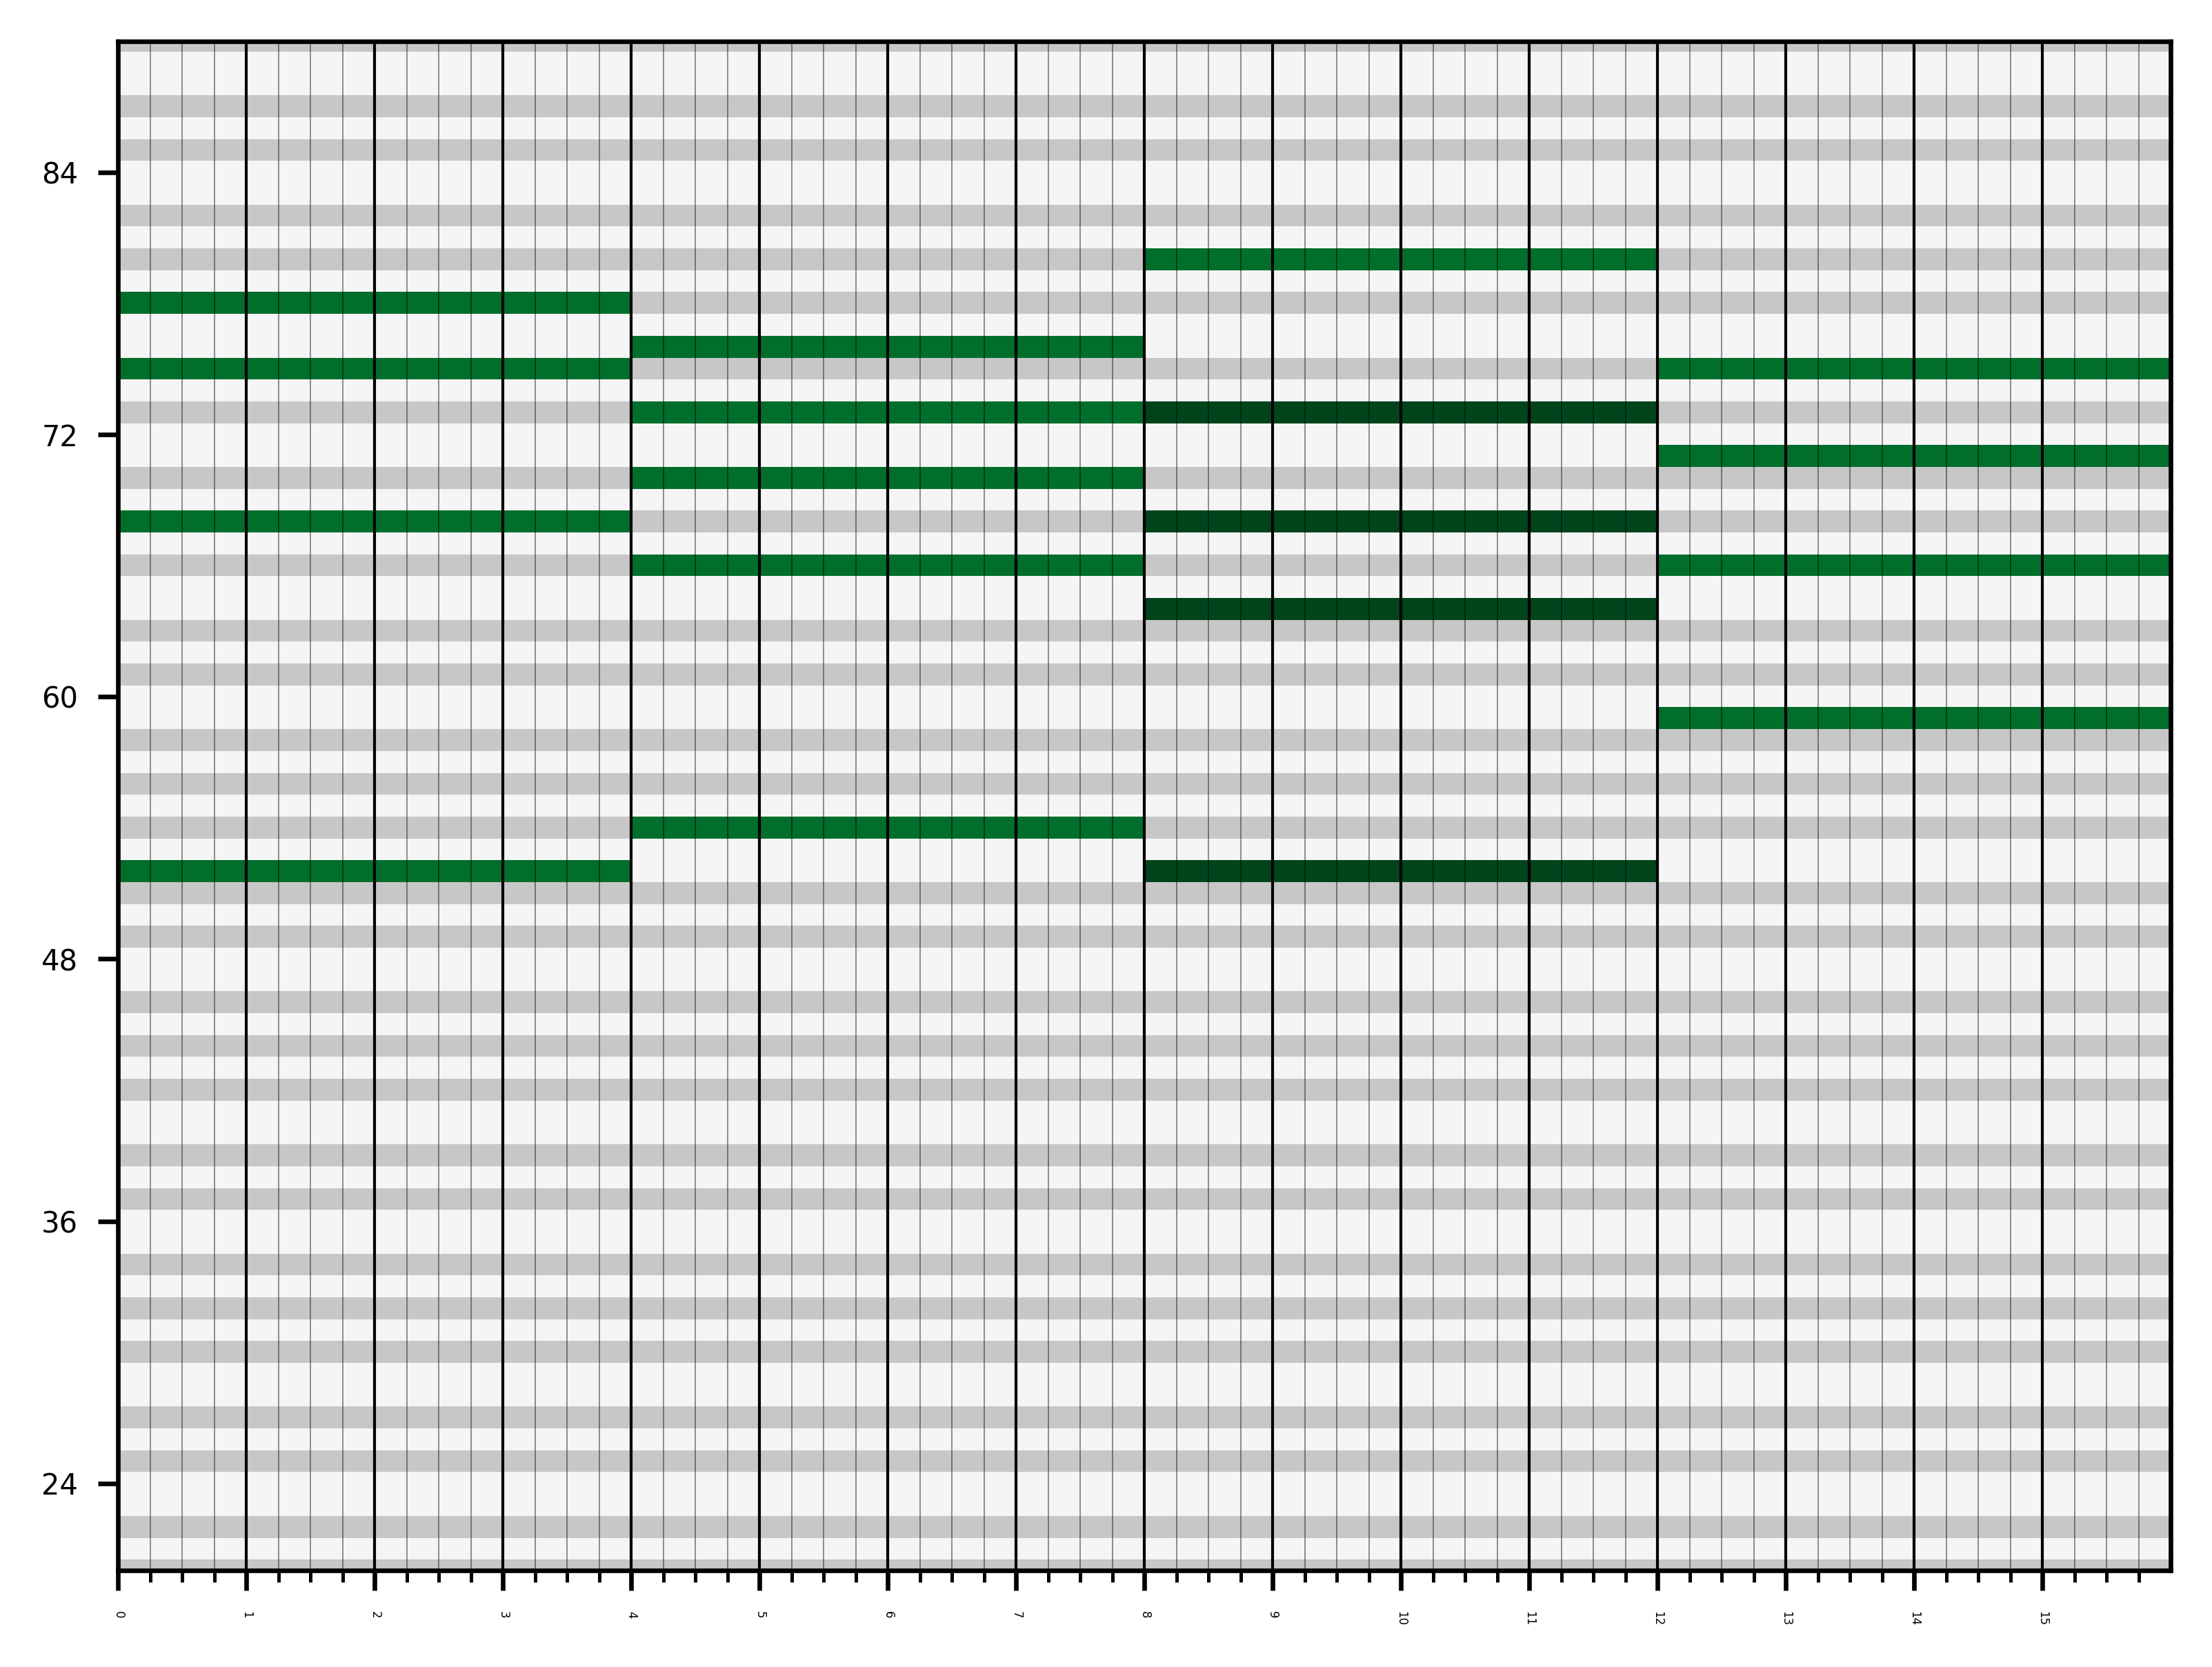

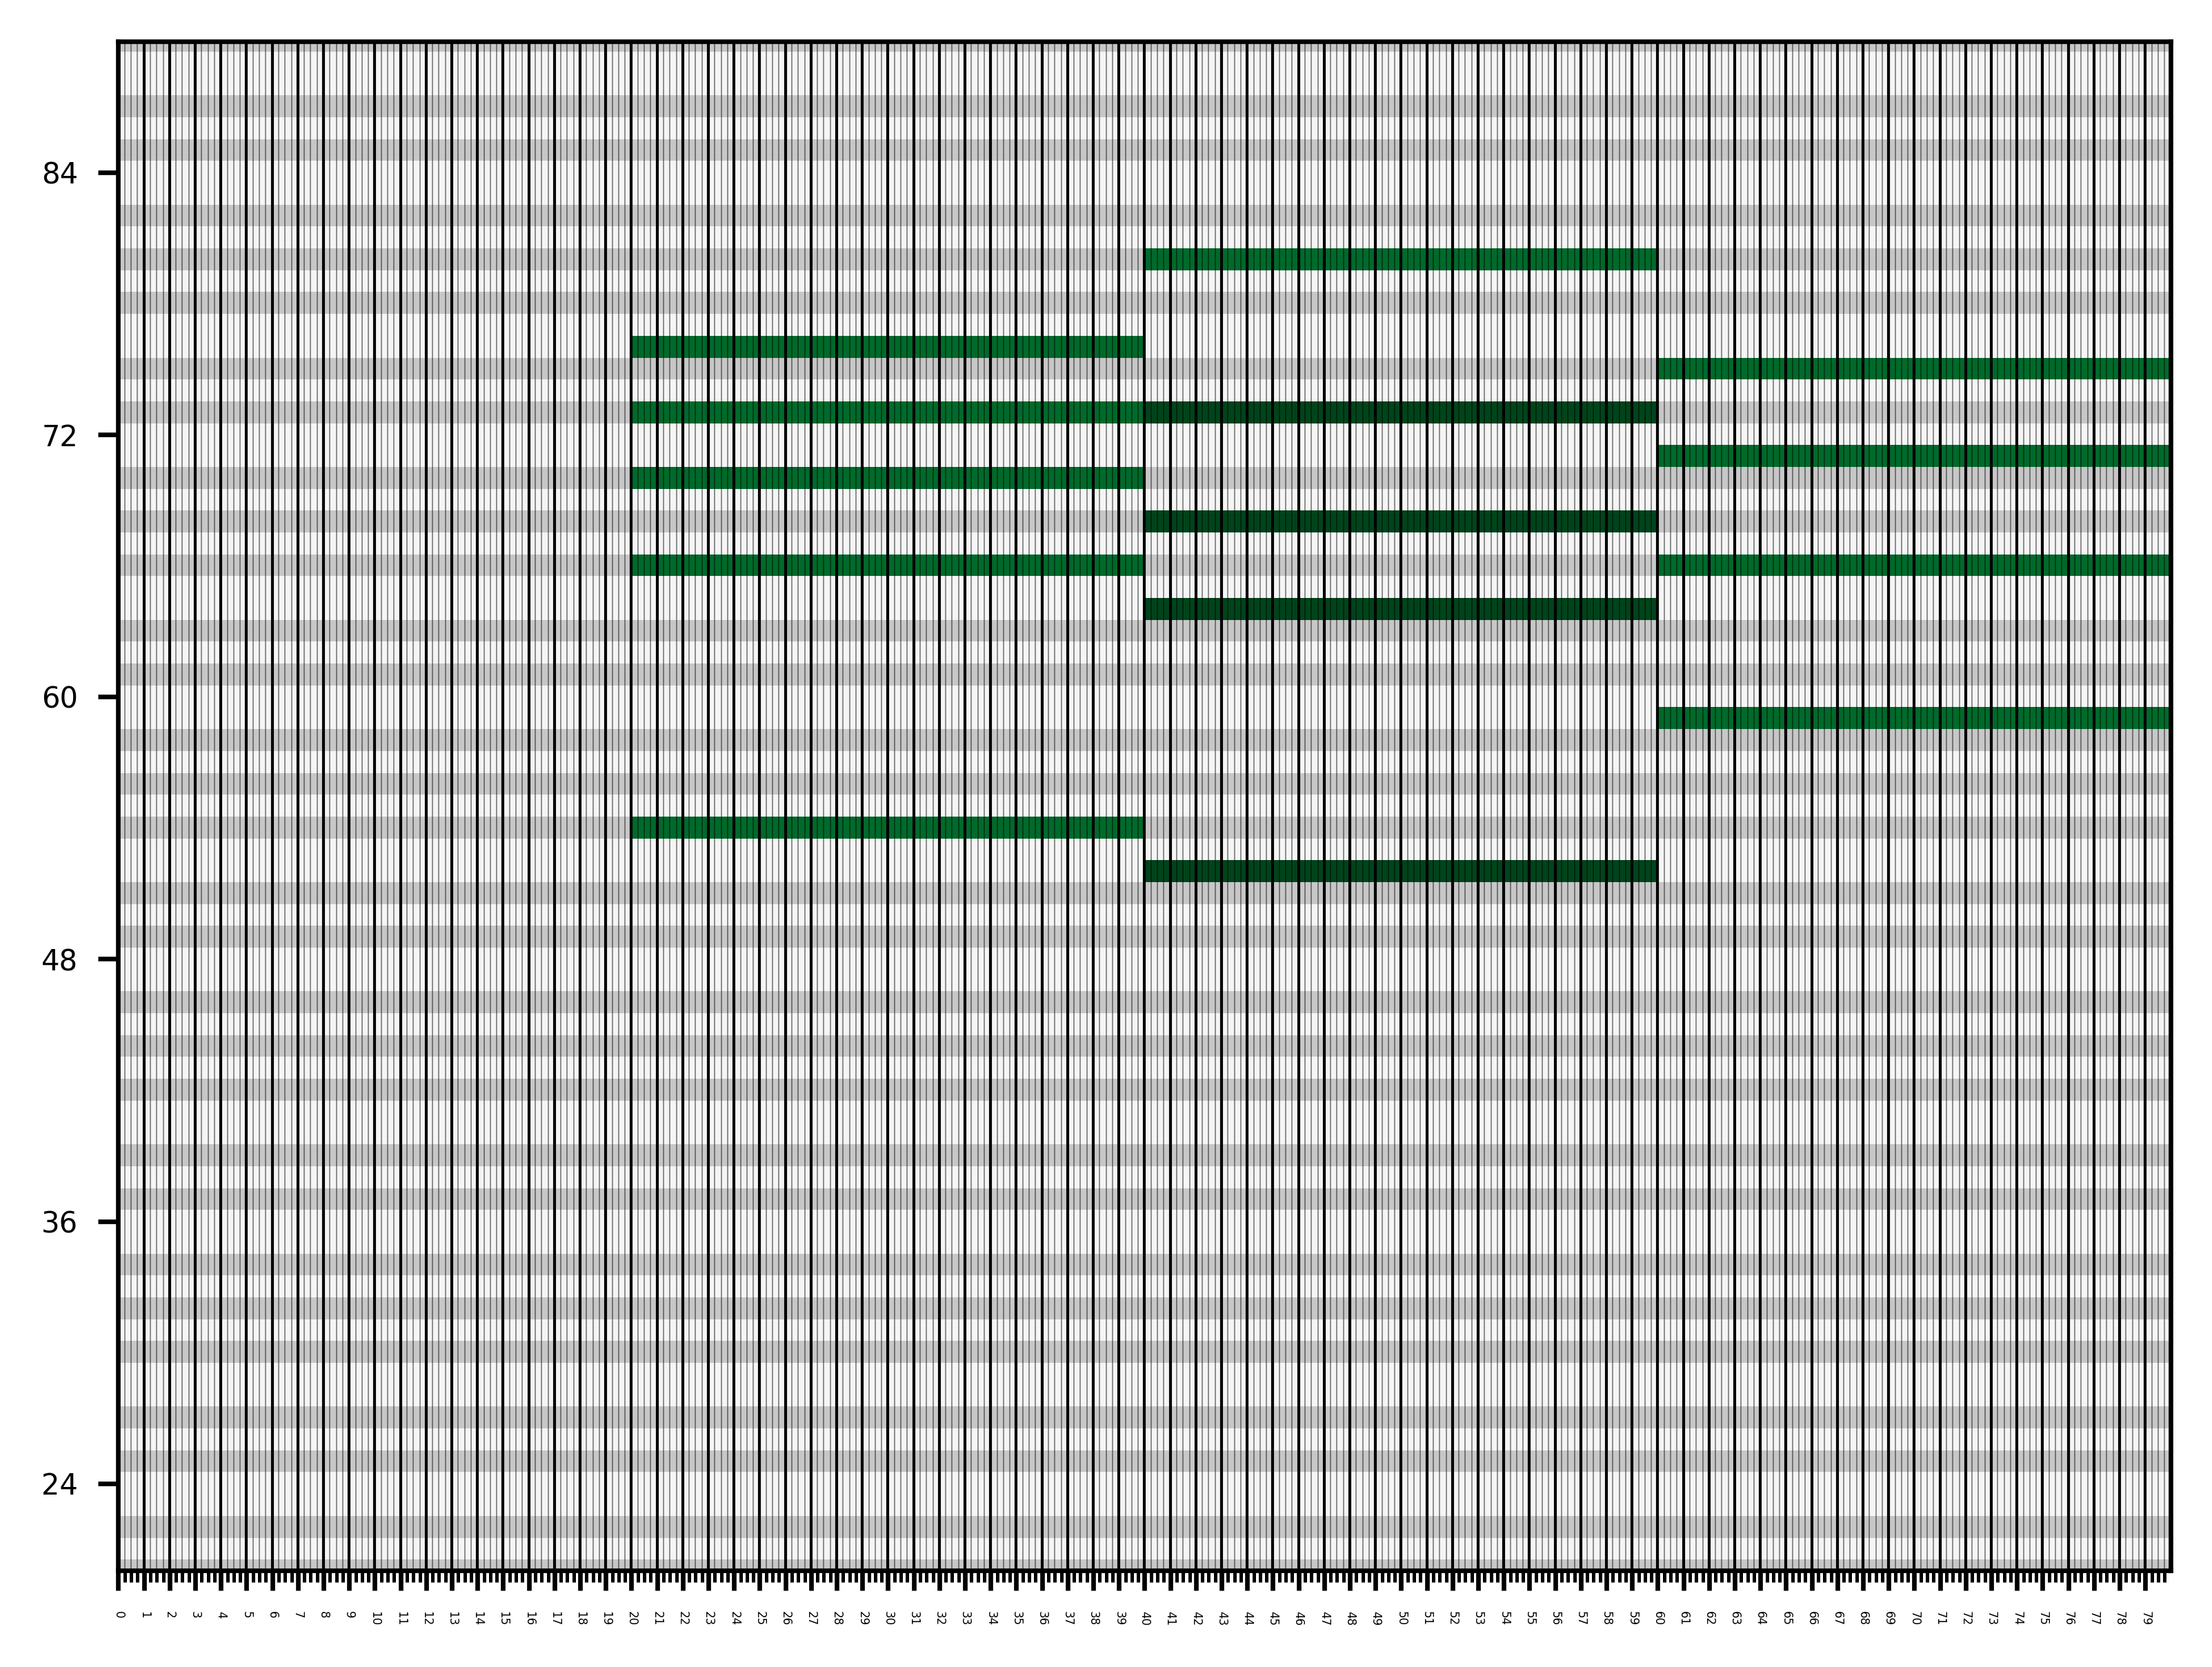

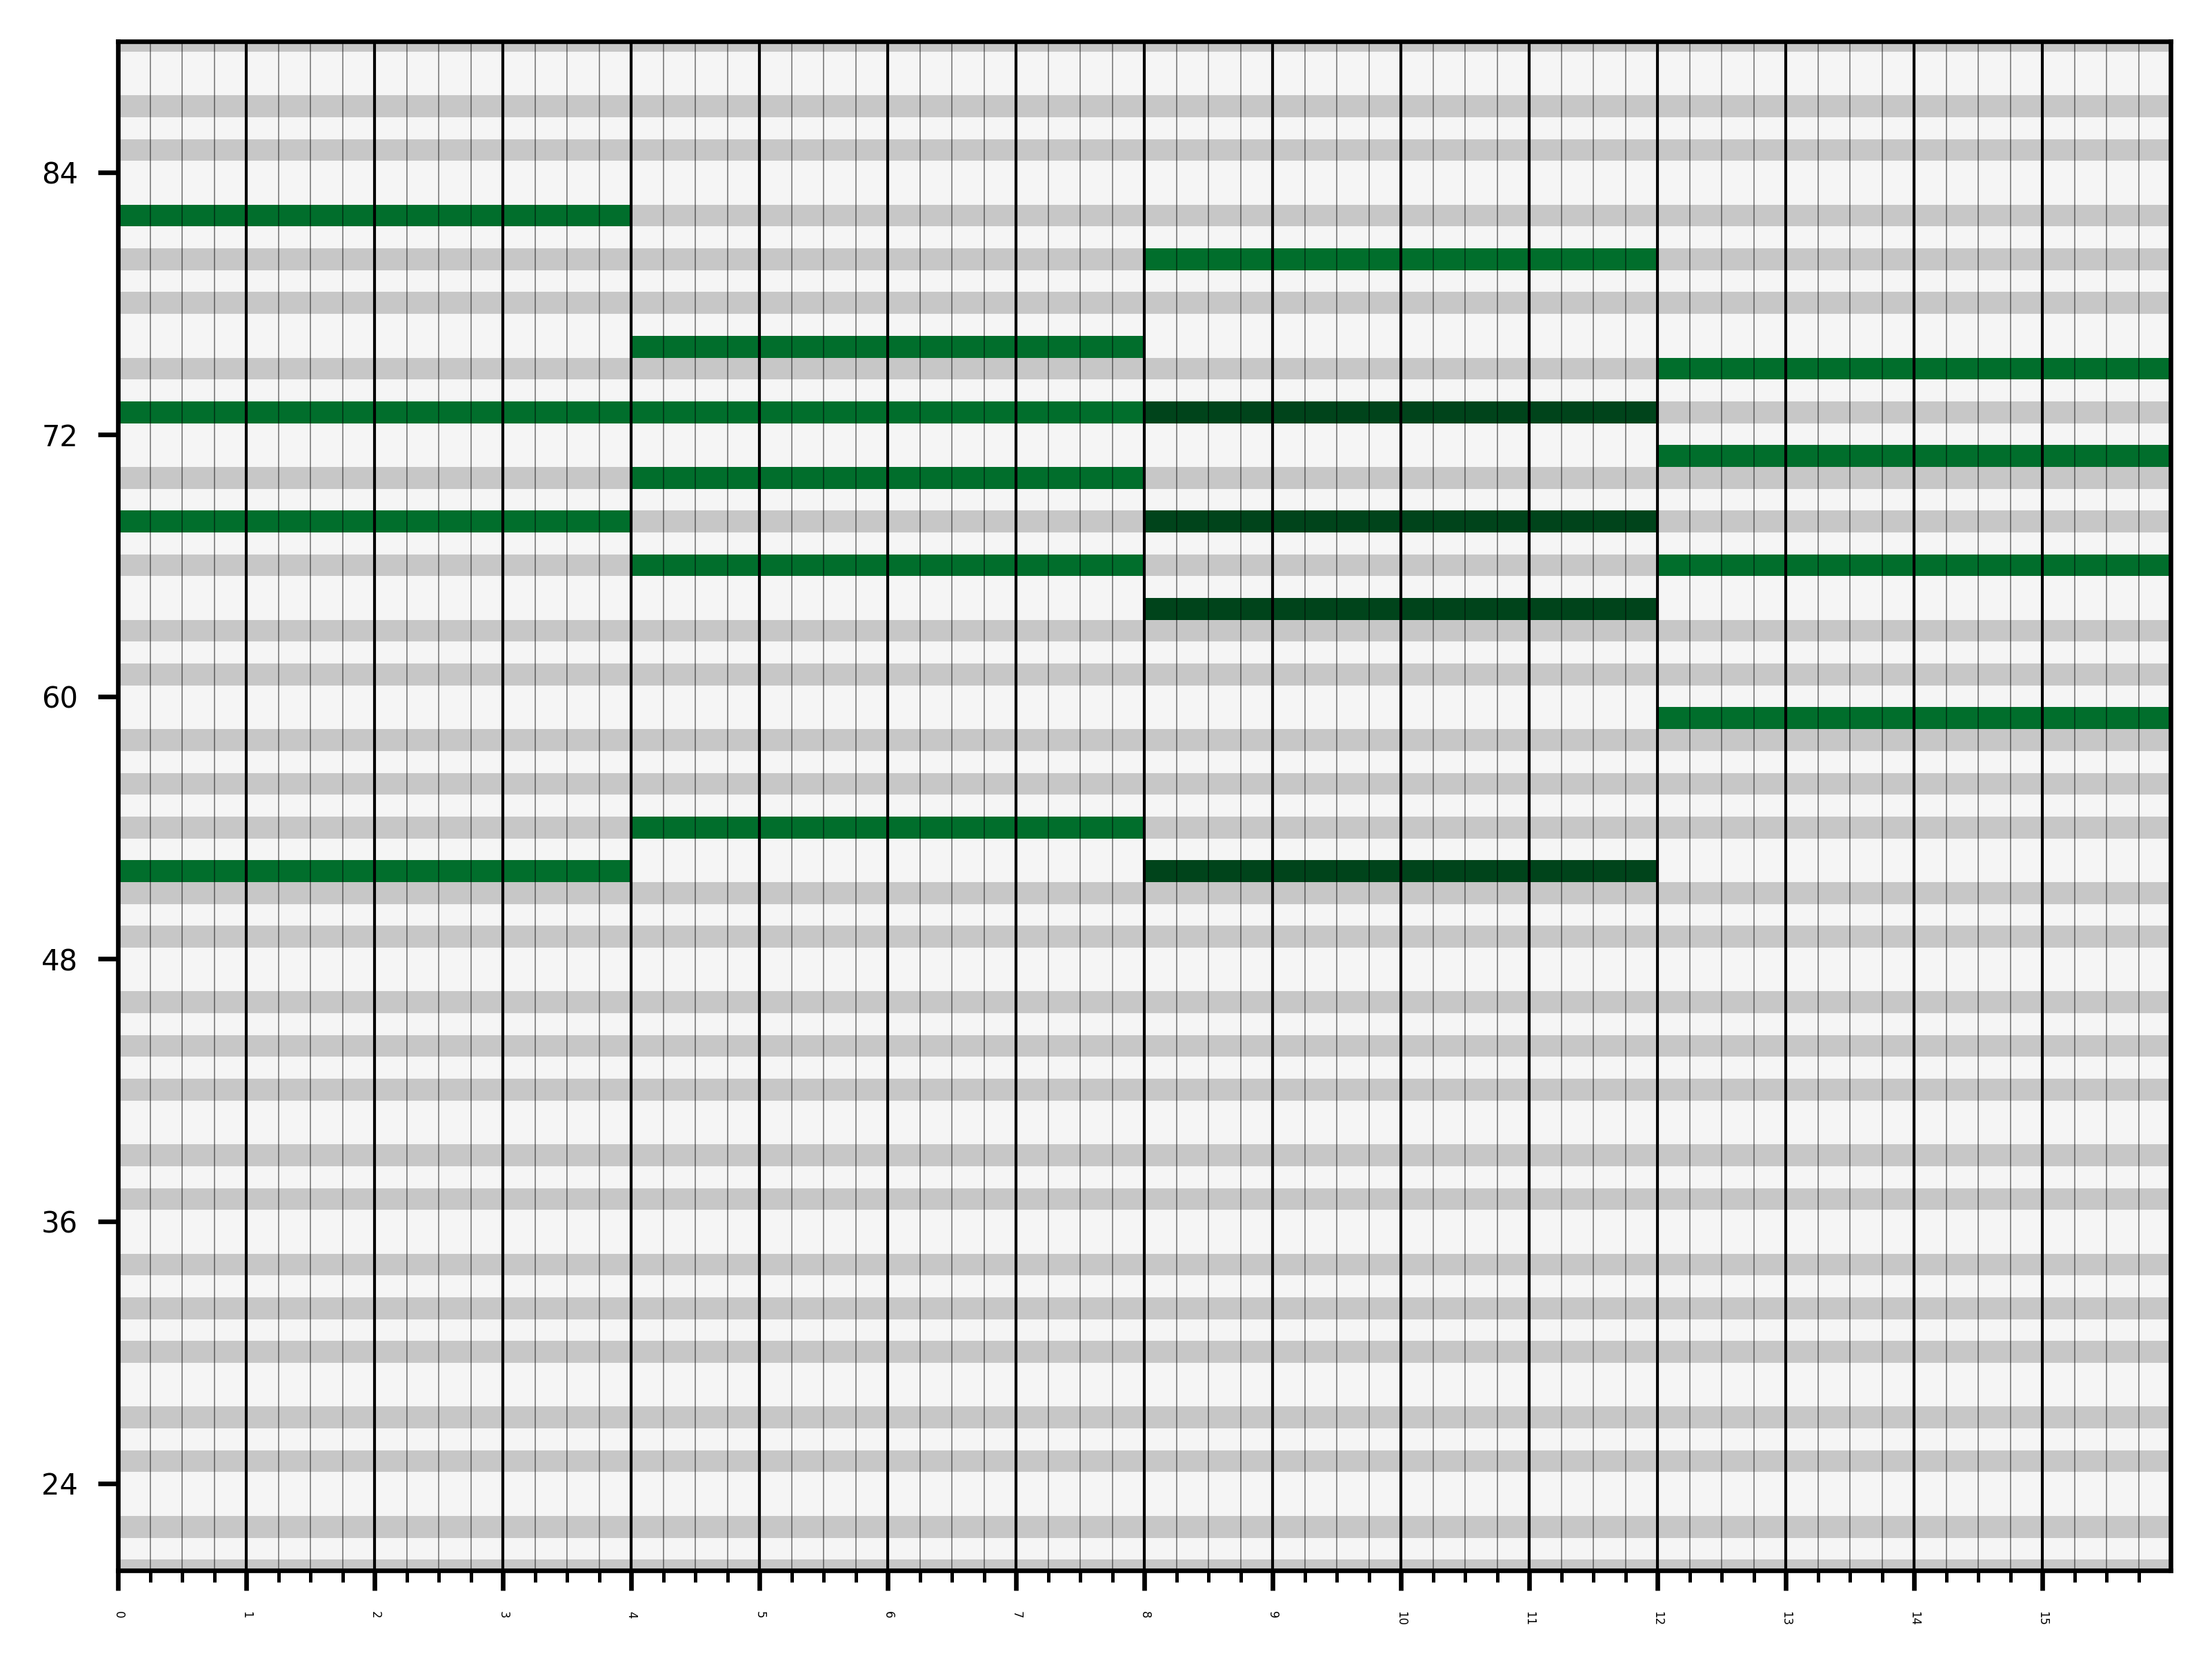

In [6]:
# Setup
filename = "midi/test3.mid" # Name of file to mask
mask_zones = [(0, 1)] # Bars to mask. Try [(1, 2), (3, 4)]!
inst = 0 # MIDI instrument to mask
plot = True # Plots Piano roll figures showing the Original MIDI, Masked area, and Predicted MIDI

# Complete MIDI
midi = miditoolkit.midi.parser.MidiFile(filename) # Get file info
for mz in mask_zones:
    print(f"Replacing chord within bar {mz[0]} to {mz[1]}")
    midi = complete_chord_prog_octuple(midi, mz[0], mz[1], inst, topk=3, plot=plot)

# Save Predicted MIDI file
save = f"{filename.split('.')[0]}_remixed_exp1.mid" # e.g. test1.mid -> test1_remixed_exp1.mid"
midi.dump(save)

<h1>Evaluation

<h3>Supporting Functions</h3>

In [7]:
# find key of file
from music21 import *
def get_key(file):
    f = converter.parse(file)
    k = f.analyze('key')
    if k.mode == "major":
        return k
    elif k.mode == "minor": # Force Major for consistency
        return k.relative
    else:
        return None

In [8]:
# Function for pitch values in a key
def is_in_key(pitch, diff):
    pitch += diff # Transpose to C
    c_major_scale = {0, 2, 4, 5, 7, 9, 11} 
    c_root = 60  # Middle C (C4) as the reference
    pitch_class = (pitch - c_root) % 12 # Copmare with C major
    return pitch_class in c_major_scale

In [11]:
import os, random
debug = False # Change to visualise process

root = "midi/evalution_samples"
test_files = os.listdir(root)
n = 0 # Counter for files
notes = dict()

# TopK Averaging
max_topk = 5
ks = dict()
for k in range(1, max_topk + 1):
    ks[k] = [] # Initialise with empty array
    notes[k] = 0
    
for filename in test_files:
    # Setup
    filename = f"{root}/{filename}"
    
    # Get key
    key = get_key(filename)
    # Get difference from C
    i = interval.Interval(key.tonic, pitch.Pitch('C'))
    difference = int(i.cents/100)
    # Get file info
    midi = miditoolkit.midi.parser.MidiFile(filename)
    
    for k in range(1, max_topk + 1):
        # Randomly mask and predict
        mask_start = random.randint(0, 3)
        mask_end = mask_start + 1
        predictions = complete_chord_prog_octuple(midi, mask_start, mask_end, 0, topk=k, plot=False, return_pitches=True, log=False)
        
        if len(predictions) == 0: # Sometimes with random masking no chords are masked, so no predictions are made
            continue
        
        # Find percentage of in-key preds
        hits = []
        for p in predictions:
            inkey = is_in_key(p, difference)
            val = 1 if inkey else 0
            hits.append(val)

        perc = round(sum(hits)/len(hits) * 100, 2) # k predictions
        ks[k].append(perc) # Add performance for this k
        notes[k] += len(predictions) # Number of preds made
        
        if debug:
            print(f"\n--\nFile: {filename}")
            print(f"key: {key}")
            print(f"k: {k}")
            print(f"diff: {difference}")
            print(f"preds: {predictions}")
            print(f"ks: {ks}")
            print(f"notes: {notes}")
    n += 1

# Analysis
sum_tot = len_tot = 0
for k in range(1, max_topk + 1):
    k_sum = sum(ks[k])
    k_len = len(ks[k])
    perc = round(k_sum/k_len, 1)
    
    print(f"\nIN-KEY Predictions for TopK = {k}:\n-- {perc}% of {notes[k]} predicted notes across {n} files were in-key.")
    sum_tot += k_sum
    len_tot += k_len

print(f"\nAverage across all K: {round(sum_tot/len_tot, 2)}")


IN-KEY Predictions for TopK = 1:
-- 70.5% of 57 predicted notes across 16 files were in-key.

IN-KEY Predictions for TopK = 2:
-- 65.0% of 56 predicted notes across 16 files were in-key.

IN-KEY Predictions for TopK = 3:
-- 65.6% of 56 predicted notes across 16 files were in-key.

IN-KEY Predictions for TopK = 4:
-- 72.0% of 61 predicted notes across 16 files were in-key.

IN-KEY Predictions for TopK = 5:
-- 69.0% of 61 predicted notes across 16 files were in-key.

Average across all K: 68.48
